In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt
#for visualising neural network
from keras.utils import plot_model

# Importing Data

In [ ]:
def func(x,y,z):
  return x**2*np.sin(y) + y**2*np.cos(z)

In [ ]:
np.random.seed(42)
num_samples = 10000
x_data = np.random.uniform(0, 1, (num_samples, 1))
y_data = np.random.uniform(-np.pi, np.pi, (num_samples, 1))
z_data = np.random.uniform(-2*np.pi, 2*np.pi, (num_samples, 1))
input_data = np.concatenate([x_data, y_data, z_data], axis=1)
output_data = func(x_data, y_data, z_data)

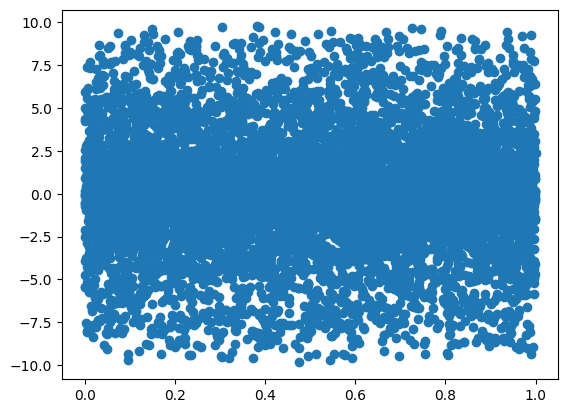

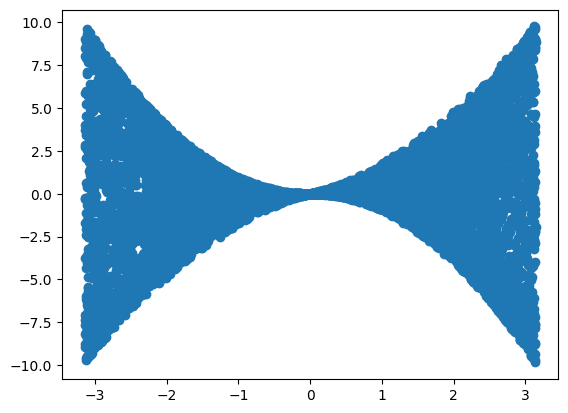

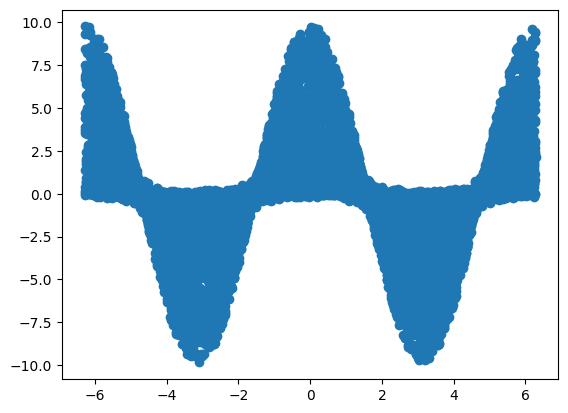

In [ ]:
plt.scatter(x_data,output_data)
plt.show()
plt.scatter(y_data,output_data)
plt.show()
plt.scatter(z_data,output_data)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 3), (2000, 3), (8000, 1), (2000, 1))

# Build Neual Network Model

In [ ]:
initalizer1 = keras.initializers.GlorotNormal
initalizer2 = keras.initializers.HeNormal

In [ ]:
# Define the custom R2 metric function
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (SS_res / (SS_tot + tf.keras.backend.epsilon()))

## Approach 1: Using Sequential Model API

In [ ]:
# Clear existing model
tf.keras.backend.clear_session()
# define model
model1 = Sequential()
model1.add(Dense(32, input_shape=(3,), activation='relu', name = 'Input', kernel_initializer=initalizer2)) #input layer
model1.add(Dense(64, activation='relu', kernel_initializer=initalizer2))
model1.add(Dense(32, activation='relu', kernel_initializer=initalizer2))
model1.add(Dense(1, name = 'Output')) # output layer
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 32)                128       
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


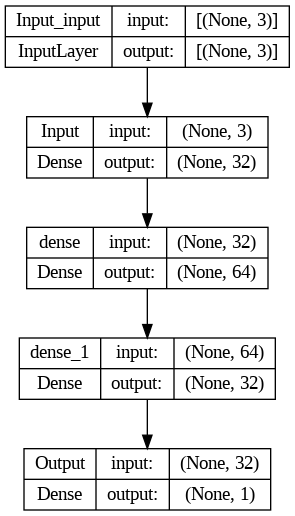

In [ ]:
plot_model(model1, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse',metrics=[r2_metric,'mape'] )

In [ ]:
#10 = 0.001, 10 = 0.0001
history = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 5s 7ms/step - loss: 0.7982 - r2_metric: 0.9097 - mape: 2047.2583 - val_loss: 0.8095 - val_r2_metric: 0.9092 - val_mape: 2079.0234
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7583 - r2_metric: 0.9138 - mape: 1918.0228 - val_loss: 0.8099 - val_r2_metric: 0.9091 - val_mape: 2214.4121
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7323 - r2_metric: 0.9176 - mape: 1707.4575 - val_loss: 0.7458 - val_r2_metric: 0.9164 - val_mape: 2088.6475
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6993 - r2_metric: 0.9217 - mape: 1727.1658 - val_loss: 0.7534 - val_r2_metric: 0.9154 - val_mape: 2049.4861
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6726 - r2_metric: 0.9246 - mape: 1640.2043 - val_loss: 0.6907 - val_r2_metric: 0.9226 - val_mape: 2123.3281
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6403

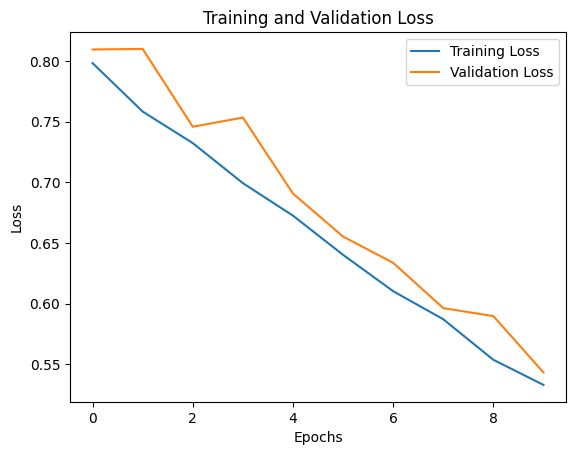

In [ ]:
# Plot epochs vs. loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_r2, test_mape = model1.evaluate(X_test, y_test)
y_testp = model1.predict(X_test)
print("Test Loss:", test_loss)
print("Test R2-score:", test_r2)
print("Test mape:", test_mape)

63/63 [==============================] - 0s 1ms/step
Test Loss: 0.47731488943099976
Test R2-score: 0.9449161887168884
Test mape: 16007.8251953125


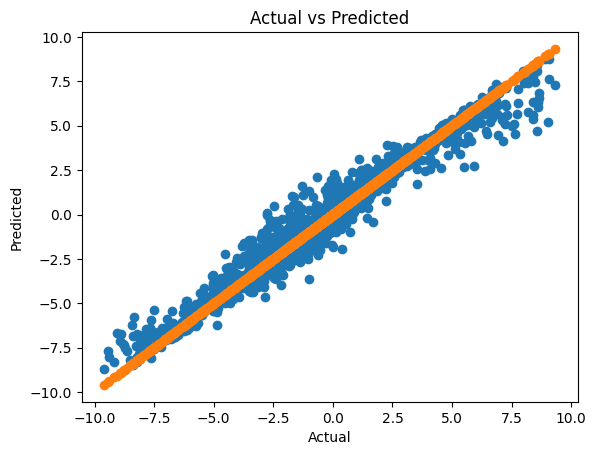

In [ ]:
plt.scatter(y_test,y_testp, label='Obtained')
plt.scatter(y_test,y_test, label='Expected')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
model1.save('model1.keras')

## Approach 2: Using Functional Model API

In [ ]:
# Clear existing model
tf.keras.backend.clear_session()
# Define input layers
input1 = Input(shape=(1,), name="Input_x")
input2 = Input(shape=(1,), name="Input_y")
input3 = Input(shape=(1,), name="Input_z")
# Add layers for input 1
x1 = Dense(32, activation='relu', kernel_initializer=initalizer2)(input1)
x1 = Dense(64, activation='relu', kernel_initializer=initalizer2)(x1)
# Add layers for input 2
x2 = Dense(32, activation='tanh', kernel_initializer=initalizer1)(input2)
x2 = Dense(64, activation='tanh', kernel_initializer=initalizer1)(x2)
x21 = Dense(32, activation='relu', kernel_initializer=initalizer2)(input2)
x21 = Dense(64, activation='relu', kernel_initializer=initalizer2)(x21)
# Add layers for input 3
x3 = Dense(32, activation='relu', kernel_initializer=initalizer2)(input3)
x3 = Dense(64, activation='relu', kernel_initializer=initalizer2)(x3)
# Merge outputs from both branches
dt1 = layers.Dot(axes=1)([x1, x2]) #layers.Concatenate()([x1, x2])
dt2 = layers.Dot(axes=1)([x21, x3])
outputs = layers.Add()([dt1,dt2])
# Output layer
#outputs = Dense(1)(s1)
# Create the model
model2 = Model(inputs=[input1, input2, input3], outputs=outputs)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_x (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Input_y (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Input_z (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 32)                   64        ['Input_x[0][0]']             
                                                                                              

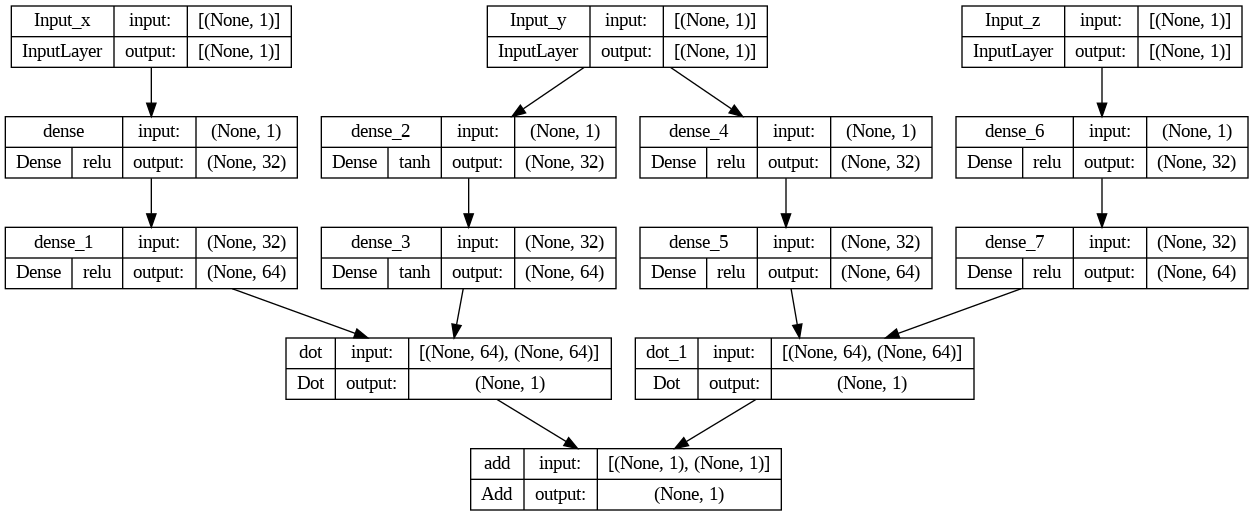

In [ ]:
plot_model(model2, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse',metrics=[r2_metric,'mape'])

In [ ]:
# 50 = 0.001
history = model2.fit([X_train[:,:1],X_train[:,1:2], X_train[:,2:3]], y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
200/200 [==============================] - 1s 5ms/step - loss: 0.5878 - r2_metric: 0.9330 - mape: 1412.3425 - val_loss: 0.5160 - val_r2_metric: 0.9441 - val_mape: 901.3005
Epoch 2/5
200/200 [==============================] - 1s 6ms/step - loss: 0.5618 - r2_metric: 0.9364 - mape: 1332.1044 - val_loss: 0.4754 - val_r2_metric: 0.9486 - val_mape: 1149.9238
Epoch 3/5
200/200 [==============================] - 1s 4ms/step - loss: 0.6017 - r2_metric: 0.9329 - mape: 1719.2913 - val_loss: 0.5919 - val_r2_metric: 0.9357 - val_mape: 1404.7942
Epoch 4/5
200/200 [==============================] - 1s 3ms/step - loss: 0.5791 - r2_metric: 0.9361 - mape: 1876.2410 - val_loss: 0.5223 - val_r2_metric: 0.9411 - val_mape: 1069.4659
Epoch 5/5
200/200 [==============================] - 1s 3ms/step - loss: 0.5284 - r2_metric: 0.9412 - mape: 1474.7043 - val_loss: 0.5105 - val_r2_metric: 0.9436 - val_mape: 1942.4861


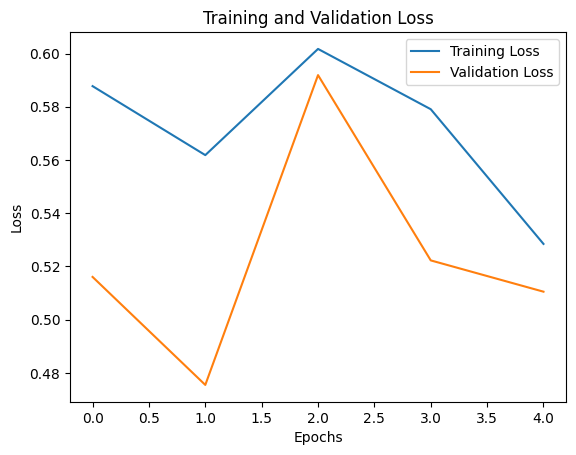

In [ ]:
# Plot epochs vs. loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_r2, test_mape = model2.evaluate([X_test[:,:1],X_test[:,1:2], X_test[:,2:3]], y_test)
y_testp = model2.predict([X_test[:,:1],X_test[:,1:2], X_test[:,2:3]])
print("Test Loss:", test_loss)
print("Test R2-score:", test_r2)
print("Test mape:", test_mape)

63/63 [==============================] - 0s 1ms/step
Test Loss: 0.5498153567314148
Test R2-score: 0.9367801547050476
Test mape: 9731.7158203125


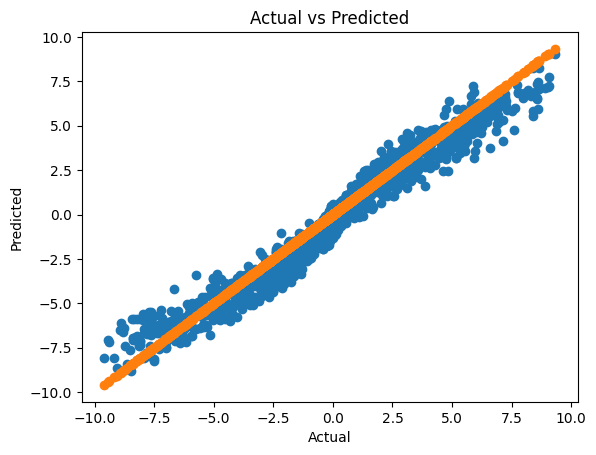

In [ ]:
plt.scatter(y_test,y_testp, label='Obtained')
plt.scatter(y_test,y_test, label='Expected')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
model2.save('model2.keras')

In [ ]:
#loading a saved model
loaded_model = load_model('/content/model1.keras', custom_objects={'r2_metric': r2_metric})

# Hyperparameter Tuning

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  act = hp.Choice('activation', values=['relu','sigmoid', 'tanh'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hl = hp.Int('layers', min_value=2, max_value=6, step=1)
  model.add(Dense(hp_units, input_shape=(3,), activation=act, name = 'Input'))
  for i in range(hl):
    model.add(Dense(units=hp_units, activation=act))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse',metrics=[r2_metric,'mape'] )
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,objective=kt.Objective("val_r2_metric", direction="max"),max_epochs=10,factor=3,directory='my_dir',project_name='intro_to_kt')

In [ ]:
tuner.search(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2)

Trial 30 Complete [00h 00m 22s]
val_r2_metric: 0.9847549200057983

Best val_r2_metric So Far: 0.9928180575370789
Total elapsed time: 00h 05m 54s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 448)               1792      
                                                                 
 dense_4 (Dense)             (None, 448)               201152    
                                                                 
 dense_5 (Dense)             (None, 448)               201152    
                                                                 
 dense_6 (Dense)             (None, 448)               201152    
                                                                 
 dense_7 (Dense)             (None, 448)               201152    
                                                                 
 dense_8 (Dense)             (None, 448)               201152    
                                                                 
 dense_9 (Dense)             (None, 448)              